## My Aprouch to the problem and conclusions

* We identifie 3 clear cluster using LDA with tf-idf approuch. We did it this way because the tf-idf vectorizer penalize the words that appear least and too much, so it's ussualy a good approuch to find the right clusters where we found a lot of subtopics, most of them related between them and very influenced by the ideas of the Republican party


* Cluster 1:
    * Very religious
    * Pro-Trump
    * Pro- Veterans
    * A lot of comments about republicans politics, specially about Roy Moore and the Alabama election for senators
    

* Cluster 2: 
    * Pro tax cuts
    * Against include girls in boys scouts
    * All the birthday saludos and thanks, specially to the president Trump and his family
    * Against inmigrants in US
    * Agains LGBT rights
    * FBI and corruption scandal for intromision of Rusia in the elections
    * Hate comments to Obama


* Cluster 3:
    * A lot of comments about the comments of the president Trump to the NFL: https://www.nytimes.com/2017/09/23/sports/trump-nfl-colin-kaepernick-.html
    
    * Talking about the fake news and the rol of the media twisting the news
    * Hate comments to Hillary Clinton
    * Agains gun control

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from itertools import chain
import re
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer        
from nltk.stem import WordNetLemmatizer 
import spacy
import string
import emoji
from time import time
from collections import Counter
# Library's to plot
import seaborn as sbs
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from sklearn.preprocessing import binarize,MinMaxScaler,RobustScaler,normalize,MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# Init the spacy object call parser
parser = spacy.load("en")

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
# A custom function to clean the text before sending it into the vectorizer
def hardCleanText(text):
    
    # get rid of newlines
    text = text.strip().replace("\n+|\n\n+|\r"," ")
    
    #Replace the newlines that are attached to a word with only the word
    newlines_finder=re.compile("\n\w+|\n\n\w+", re.IGNORECASE)
    w=newlines_finder.findall(text)
    for t in w:
        if len(t.split('\n\n'))>1:
            text=re.sub(t,t.split('\n\n')[1],text)
        else:
            text=re.sub(t,"",text)
    
    #get rid of the symbols before the ' with the word in the sentence. Examples: \'t, \'m , etc
    text=re.sub(r'\'',"",text)
    
      # replace twitter the symbol of the user names
    hashtag_finder = re.compile(r"(?:\@)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
    # replace hashtags
    hashtag_finder = re.compile(r"(?:\#)", re.IGNORECASE)
    text = hashtag_finder.sub("", text)
    
      # replace numbers
    number_finder =re.compile(r"\s?[0-9]+\.?[0-9]*")
    text = number_finder.sub("", text)
    
    # Replace phone numbers
    phone_number_finder=re.compile(r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?            
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?    
      \d{3}          # exchange
      [\-\s.]*   
      \d{4}          # base
    )""", re.IGNORECASE)
    text = phone_number_finder.sub(" ", text)
    
    # replace HTML symbols
    text=text.replace("&amp;", "and")
    
    # delete especial characters and some HTML symbols
    for remove in map(lambda r: re.compile(re.escape(r)),[",", ":", "\"", "=", "&", ";", "%", "$", "%", "^", "*","(", ")", 
                       "{", "}","[", "]", "|", "/", "\\",">","<","-","!","?", ".", "'",
                       "--", "---","&gt;","&lt;","-----", "---", "...", "“", "”", "'ve"]):
        text=remove.sub(" ",text)
    
    #Get only one space of separation when there is one or more spaces
    text=text.replace(r'\s',' ')

    return text

In [4]:
def tokenizer(doc,parser=parser,stem=False,lemma=True,stop_words=True,min_words=2,only_alpha=True,digit=True):
    
    doc = parser(doc)
    tokens=[token for token in doc if not (token.is_punct or token.is_space or token.is_quote)]
    
    if(not digit):
         tokens=[token for token in tokens if not (token.is_digit)]
    
    if(only_alpha):
        tokens=[token for token in doc if (token.is_alpha)]
    
    if(stop_words):
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if not (token.lower_ in stop_words)]
    
    if(min_words>1):
        tokens = [token for token in tokens if len(token) >= min_words]
    
    if(stem & lemma):
        stem = SnowballStemmer('english')
        tokens = [token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
        tokens = [stem.stem(token).lower() for token in tokens if token not in string.punctuation]
    elif(lemma):
        tokens = [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
    elif(stem):
        stem = SnowballStemmer('english')
        tokens = [stem.stem(token.lower_) for token in tokens if not (token.is_punct)]
    
    return tokens

In [5]:
df = pd.read_csv('train-data-1513704817538.csv')
print(df.shape)
df.head()

(12627, 2)


,case,message
0,NEGATIVE,She/he was elected because???
1,NEGATIVE,That a elective surgery. So NO
2,POSITIVE,Danica roem is a mentally ill freak. this sick...
3,NEGATIVE,I would gladly paid for psiquiatric treatment....
4,NEGATIVE,NO! You must pay for it yourself. You were n...


## Pre-processing

#### Create the clean message

In [6]:
df.loc[:,"clean_message"]=df.loc[:,"message"].apply(lambda x: hardCleanText(x)).copy()

In [7]:
df.clean_message.head(3)

0                        She he was elected because   
1                       That a elective surgery  So NO
2    Danica roem is a mentally ill freak  this sick...
Name: clean_message, dtype: object

#### Extract the common words with their relative weights

In [8]:
df.loc[:,"tokenize_message"]=df.loc[:,"clean_message"].apply(lambda x: tokenizer(x,parser,stop_words=True)).copy()

In [9]:
def create_common_words(max_occurrences=np.infty,min_occurrences=10,words=None):
    word_df = pd.DataFrame(
        data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurrences],
              "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurrences]},
        columns=["word", "occurrences"])
    return word_df

In [10]:
words = Counter()
for idx in df.index:
    words.update(df.loc[idx, "tokenize_message"])
words.most_common(5)

[('not', 1768), ('get', 1328), ('go', 1188), ('people', 1090), ('good', 1022)]

In [11]:
stop_words = stopwords.words('english')
whitelist = []
blacklist=['@number','@hashtag','@mentions']
for idx, stop_word in enumerate(stop_words):
    if stop_word not in whitelist:
        del words[stop_word]
for idx,black_word in enumerate(blacklist):
    del words[black_word]
words.most_common(5)

[('get', 1328), ('go', 1188), ('people', 1090), ('good', 1022), ('trump', 984)]

In [12]:
common_words=create_common_words(words=words)
common_words['weight']=common_words.occurrences/max(common_words.occurrences)
print(common_words.shape)
common_words.head(10)

(1537, 3)


,word,occurrences,weight
0,get,1328,1.000000
1,go,1188,0.894578
2,people,1090,0.820783
3,good,1022,0.769578
4,trump,984,0.740964
5,president,956,0.719880
6,like,925,0.696536
7,need,873,0.657380
8,god,786,0.591867
9,would,784,0.590361


         word  occurrences    weight
0         get         1328  1.000000
1          go         1188  0.894578
2      people         1090  0.820783
3        good         1022  0.769578
4       trump          984  0.740964
5   president          956  0.719880
6        like          925  0.696536
7        need          873  0.657380
8         god          786  0.591867
9       would          784  0.590361
10        one          782  0.588855
11        say          746  0.561747
12       make          661  0.497741
13        man          642  0.483434
14       time          633  0.476657
15      think          619  0.466114
16    country          619  0.466114
17      thank          608  0.457831
18       know          561  0.422440
19       love          510  0.384036


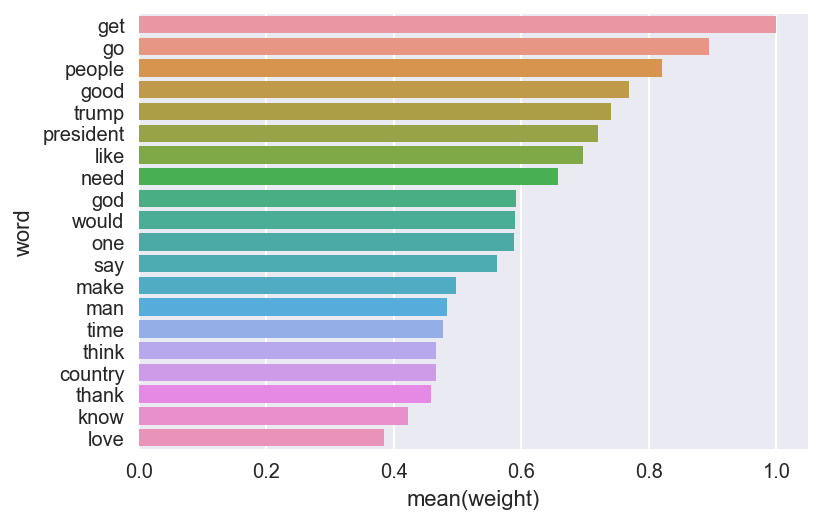

In [13]:
top_20_pos=common_words[['word','occurrences','weight']].sort_values(by='weight',ascending=False).head(20)
print(top_20_pos)
sbs.barplot(x='weight', y='word', data=top_20_pos);

In [14]:
words_dict=common_words[['word','weight']].apply(lambda x: {x['word']:x['weight']},axis=1)
words_dict=list(words_dict)
words_dict[0:3]

[{'get': 1.0}, {'go': 0.8945783132530121}, {'people': 0.8207831325301205}]

### Create the vectors

In [15]:
# Print the head of df
X=df.iloc[:,range(1,df.shape[1])]

In [16]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenizer,strip_accents ='unicode',min_df=10,ngram_range=(1,2))

dtm_tfidf = tfidf_vectorizer.fit_transform(X.clean_message)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

['abc', 'abide', 'ability', 'able', 'abortion', 'absolute', 'absolutely', 'abuse', 'accept', 'accomplish']


## Visualize the Clusters

#### Exploring the clusters

* After we create the topis Using the LDA algorithm, we are going to visualize it using the pyLDAvis library, which extracts information from a topic model and creates a web-based visualization where users can interactively explore the model 

* To understand what's going on we are going to label our data using LDA model with the number of the topic which has the best probability to match with the sentence. To do that we have created a function which will be apllied to the "clean_message" column row by row

* Also, we would like to do the same for the nmf cluster, so we are going to display the full text of the main docs for each topic, so we are going to create the display_topic() function

**References: **

*<https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/>*

*<https://nlpforhackers.io/topic-modeling/>*

*<https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730>*

*<https://towardsdatascience.com/improving-the-interpretation-of-topic-models-87fd2ee3847d>*

*<https://github.com/bmabey/pyLDAvis>*

In [17]:
def get_cluster(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    for i in range(0,9):
        if(x[i]==x.max()):
            return(i)
        
def get_cluster_prob(model,vectorizer,text):
    x = model.transform(vectorizer.transform([text]))[0]
    return(x.max())

In [18]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [34]:
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar

def get_similars(X,text,model,vectorizer):
    x = nmf_model.transform(vectorizer.transform([text]))[0]
    similarities = most_similar(x, model)
    document_id, similarity = similarities[1]
    print(X[document_id])
    document_id, similarity = similarities[2]
    print(X[document_id])
    document_id, similarity = similarities[3]
    print(X[document_id])
    document_id, similarity = similarities[4]
    print(X[document_id])

In [20]:
no_topics =3

In [21]:
# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=50, learning_method='online', 
                                      learning_offset=50.,random_state=0).fit(dtm_tfidf)
lda   = lda_model.fit(dtm_tfidf)
lda_W = lda_model.transform(dtm_tfidf)
lda_H = lda_model.components_

In [23]:
pyLDAvis.sklearn.prepare(lda_model, dtm_tfidf, tfidf_vectorizer, mds='PCoA')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      42.321098        1       1 -0.057047 -0.240339
1      28.884353        1       2 -0.199740  0.165218
2      28.794549        1       3  0.256786  0.075121, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
703   Default  168.000000         god  168.000000  30.0000  30.0000
1047  Default  140.000000         man  140.000000  29.0000  29.0000
1992  Default   94.000000         yes   94.000000  28.0000  28.0000
1696  Default   91.000000      stupid   91.000000  27.0000  27.0000
969   Default   92.000000     liberal   92.000000  26.0000  26.0000
1829  Default  172.000000       trump  172.000000  25.0000  25.0000
733   Default  123.000000       great  123.000000  24.0000  24.0000
830   Default   81.000000       idiot   81.000000  23.0000  23.0000
1014  Default  134.000000        love  134.000000  22.0000  22.0000
950   Default   80.000000       leave   80.000000  21.0000  21.0000
1004  Default   79.000000        look   79.000000  20.0000  20.0000
183   Default  117.000000       bless  117.000000  19.0000  19.0000
1116  Default   69.000000          mr   69.000000  18.0000  18.0000
704   Default  102.000000   god bless  102.000000  17.0000  17.0000
1727  Default  108.000000        take  108.000000  16.0000  16.0000
976   Default   67.000000         lie   67.000000  15.0000  15.0000
1793  Default  136.000000        time  136.000000  14.0000  14.0000
36    Default   65.000000       agree   65.000000  13.0000  13.0000
1686  Default   65.000000        stop   65.000000  12.0000  12.0000
166   Default   64.000000         big   64.000000  11.0000  11.0000
1220  Default   64.000000     nothing   64.000000  10.0000  10.0000
1164  Default   62.000000        news   62.000000   9.0000   9.0000
1917  Default   94.000000         way   94.000000   8.0000   8.0000
1170  Default   63.000000         nfl   63.000000   7.0000   7.0000
938   Default   64.000000         law   64.000000   6.0000   6.0000
205   Default   58.000000         boy   58.000000   5.0000   5.0000
1377  Default  186.000000   president  186.000000   4.0000   4.0000
1826  Default   55.000000        true   55.000000   3.0000   3.0000
1770  Default   82.000000       thing   82.000000   2.0000   2.0000
884   Default   82.000000         job   82.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1595   Topic3   37.768460        shut   38.450069   1.2271  -5.4822
314    Topic3   36.671174         cnn   37.333257   1.2271  -5.5117
1432   Topic3   39.299589      racist   40.012108   1.2270  -5.4425
244    Topic3   37.093770  california   37.792450   1.2263  -5.5003
1134   Topic3   39.280361        must   40.047677   1.2256  -5.4430
909    Topic3   35.772657        kill   36.505680   1.2247  -5.5365
484    Topic3   32.378281        dumb   33.049584   1.2245  -5.6362
1942   Topic3   32.938810        will   33.622114   1.2245  -5.6191
1113   Topic3   31.276503       mouth   31.965257   1.2232  -5.6709
1943   Topic3   29.696176    will not   30.374824   1.2224  -5.7227
747    Topic3   29.295546         gun   29.970750   1.2222  -5.7363
357    Topic3   30.450534     corrupt   31.156418   1.2221  -5.6976
1133   Topic3   29.947340      muslim   30.662178   1.2214  -5.7143
1170   Topic3   61.527965         nfl   63.896945   1.2072  -4.9942
1631   Topic3   45.375253     someone   49.944425   1.1490  -5.2988
1889   Topic3   54.756299        vote   70.353235   0.9943  -5.1108
662    Topic3  129.069614         get  237.722191   0.6342  -4.2534
1320   Topic3   39.379957      person   45.277618   1.1054  -5.4405
920    Topic3   74.304062        know  120.213003   0.7639  -4.8056
1773   Topic3   74.697251       think  141.876638   0.6035  -4.8003
424    Topic3   51.818357    democrat   77.443195   0.8432  -5.1660
1146   Topic3  

In [24]:
df['tfidf_cluster']=df.clean_message.apply(lambda x: get_cluster(model=lda_model,vectorizer=tfidf_vectorizer,text=x))
df['tfidf_cluster_prob']=df.clean_message.apply(lambda x: get_cluster_prob(model=lda_model,vectorizer=tfidf_vectorizer,text=x))

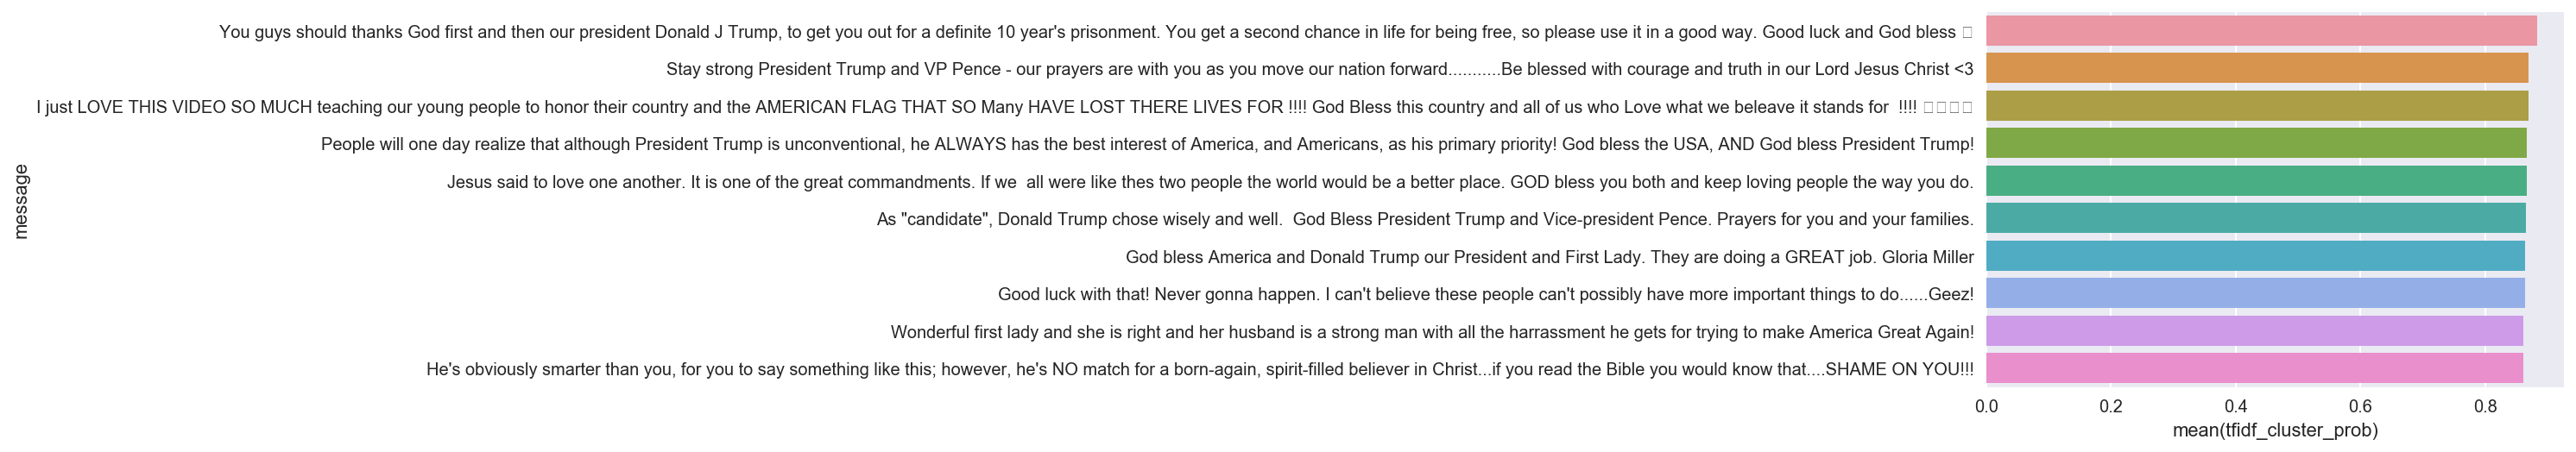

In [48]:
top_10_docs=df[df.tfidf_cluster==0][['message','tfidf_cluster_prob']].sort_values(by='tfidf_cluster_prob',ascending=False).head(10)
sbs.barplot(x='tfidf_cluster_prob', y='message', data=top_10_docs);

In [28]:
df[df.tfidf_cluster==1].to_csv('df_tfidf_cluster.csv',sep=";",index=False)